# Object Search with Quadtree
Implement the algorithm of the paper [A Quadtree-based Spatial Object Search Scheme](https://www.ijcse.com/docs/INDJCSE20-11-02-109.pdf).  

Implement object search as a function with quadtree and brute force, and compare the execution times of two functions.  
In addition, implement functions to visualize the object and calculate the area using the quadtree.  

Same as the test environment of the paper, an image with transparency is input.  
Also, assume that the transparent pixel, which has a transparency level of 0, has no object, and the nontransparent pixel, which has a transparency level of 1-255, has an object.  

## 0. Import modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import time
import cv2
from PIL import Image
%matplotlib inline

print(Image.__version__)
print(np.__version__)
print(matplotlib.__version__)
print(cv2.__version__)

7.2.0
1.19.0
3.2.2
4.3.0


## 1. Define functions

### 1.1 load_image
It is a function that loads an image by taking the path of an image as an argument.  
If an image file with no transparency is loaded, an error occurs at `line 4`.  

In [2]:
def load_image(img_path):
    _im = Image.open(img_path)
    _im = np.array(_im)/255
    _obj = _im[:, :, 3] # stores only A value of RGBA
    _area = (_obj > 0).sum()
    return _im, _obj, _area

### 1.2 quadtree_search
It is a recursive function that saves the result of searching an object in an image as a quadtree data structure.  

In [3]:
def quadtree_search(max_x, max_y, min_x=0, min_y=0, current_x=0, current_y=0, level=1, index=0):
    
    '''Temporarily store the coordinates to start searching at the current level'''
    _x, _y = current_x, current_y
    
    '''Determines the coordinates at which to start searching in the current level'''
    if max_x < current_x:
        return _
    elif (min_x <= current_x <= max_x) and not (min_y <= current_y <= max_y):
        _y = min_y
        if min_y < current_y:
            _x += 1
    elif current_x < min_x:
        _x, _y = min_x, min_y
    
    '''Start search at the determined coordinates'''
    for i in range(_x, max_x + 1):
        for j in range(_y, max_y + 1):
            if obj[j][i] != 0: # pixel's transparency is not 0 → object exists
                quadtree[index] = 1 # update quadtree managed as a one-dimensional array
                if setting_level > level: # recursive call when the current level is less than the depth of quadtree
                    _half_x, _half_y = int((max_x - min_x + 1) / 2), int((max_y - min_y + 1) / 2)
                    quadtree_search(min_x + _half_x - 1, min_y + _half_y - 1, min_x, min_y, i, j, level + 1, index * 4 + 1)
                    quadtree_search(max_x, min_y + _half_y - 1, min_x + _half_x, min_y, i, j, level + 1, index * 4 + 2)
                    quadtree_search(min_x + _half_x - 1, max_y, min_x, min_y + _half_y, i, j, level + 1, index * 4 + 3)
                    quadtree_search(max_x, max_y, min_x + _half_x, min_y + _half_y, i, j, level + 1, index * 4 + 4)
                return _

### 1.3 brute_force
It is a function that searching an object in an image as brute force.  

In [4]:
def brute_force(max_x, max_y):
    for i in range(max_x + 1):
        for j in range(max_y + 1):
            if obj[j][i] != 0: # pixel's transparency is not 0 → object exists
                obj[j][i] = obj[j][i]

### 1.4 draw_from_tree
It is a function that visualizes the object based on quadtree.  

In [5]:
def draw_from_tree(max_x, max_y, min_x=0, min_y=0, level=1, index=0):
    
    '''Create white drawing paper'''
    _approx_obj = np.ones((max_x + 1, max_y + 1, 3))
    
    '''Draw the object on drawing paper and return it'''
    if quadtree[index] == 0: # 1. object does not exist in the node
        if index > 0:
            return []
        elif index == 0: # if no object exists in the root node, white drawing paper is returned
            return _approx_obj
    elif quadtree[index] == 1: # 2. object exists in the node
        if setting_level == level: # when the current level is the depth of the quadtree
            _coor = [(min_x, max_x, min_y, max_y)] # save the coordinates of the object
        elif setting_level > level: # recursive call when the current level is less than the depth of quadtree
            _half_x, _half_y = int((max_x - min_x + 1) / 2), int((max_y - min_y + 1) / 2)
            _coor = (
                draw_from_tree(min_x + _half_x - 1, min_y + _half_y - 1, min_x, min_y, level + 1, index * 4 + 1) +
                draw_from_tree(max_x, min_y + _half_y - 1, min_x + _half_x, min_y, level + 1, index * 4 + 2) +
                draw_from_tree(min_x + _half_x - 1, max_y, min_x, min_y + _half_y, level + 1, index * 4 + 3) +
                draw_from_tree(max_x, max_y, min_x + _half_x, min_y + _half_y, level + 1, index * 4 + 4)
            )
        if index > 0:
            return _coor
        elif index == 0: # draw the object on a drawing paper using the coordinates saved by recursive call, and return it
            for i in _coor:
                _min_x, _max_x, _min_y, _max_y = i
                _approx_obj = cv2.rectangle(_approx_obj, (_min_x, _min_y), (_max_x, _max_y), (0., 0., 0.), -1)
            return _approx_obj

### 1.5 calc_area
It is a recursive function that calculates the area based on quadtree.  

In [6]:
def calc_area(x, y, level=1, index=0):
    if quadtree[index] == 0: # 1. object does not exist in the node
        return 0
    elif quadtree[index] == 1: # 2. object exists in the node
        if setting_level == level: # when the current level is the depth of the quadtree
            _approx_area = int(x/2**(level-1)) * int(y/2**(level-1)) # calculate the area of the node
        elif setting_level > level: # recursive call when the current level is less than the depth of quadtree
            _approx_area = (
                calc_area(x, y, level + 1, index * 4 + 1) +
                calc_area(x, y, level + 1, index * 4 + 2) +
                calc_area(x, y, level + 1, index * 4 + 3) +
                calc_area(x, y, level + 1, index * 4 + 4)
            )
        return _approx_area

## 2. Execute

### 2.1 Set variables and import image
Set two variables.  
* setting_level: Depth of quadtree  
* img_path: Path of an image  

Set variables referring to the precautions.  
1. Use an image file with transparency such as *.png files.  
2. Use an image file with a width and height of `2^n px`.  
3. If the depth of quadtree is set to be greater than `n`, the number of searches for the proposed scheme is greater than brute force.  

The saved test image is `512 px` in width and height.  
Therefore, when the depth of the quadtree exceeds `9`, the number of searches of the proposed scheme is greater than brute force.  

(1365,)
(512, 512, 4) (512, 512)


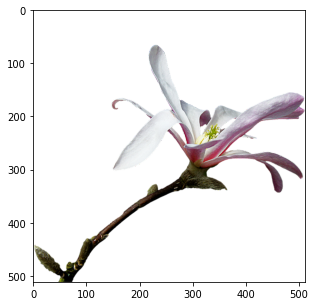

In [7]:
setting_level = 6
img_path = './test_images/test_image_06.png'

'''Initialize a quadtree managed as a one-dimensional array'''
quadtree = np.zeros(sum([4**x for x in range(setting_level)]))
print(quadtree.shape)

'''Import an image'''
im, obj, area = load_image(img_path)
x, y = im.shape[0], im.shape[1]
max_x, max_y = x - 1, y - 1
print(im.shape, obj.shape)

'''Show the imported image'''
plt.figure(figsize=(5, 5))
plt.imshow(im)
plt.show()

### 2.2 Search the object
The object is searched using the two implemented functions, and compare the execution time.  

In [8]:
start = time.time()
quadtree_search(max_x=max_x, max_y=max_y)
print('Execution time of the quadtree search:', time.time() - start)

start = time.time()
brute_force(max_x, max_y)
print('Execution time of the brute force:', time.time() - start)

print(quadtree) # print a one-dimensional array(quadtree) returned from the quadtree_search function

Execution time of the quadtree search: 0.1126551628112793
Execution time of the brute force: 0.14245820045471191
[1. 1. 1. ... 0. 0. 0.]


### 2.3 Visualize the object
Visualize the object using the quadtree.  

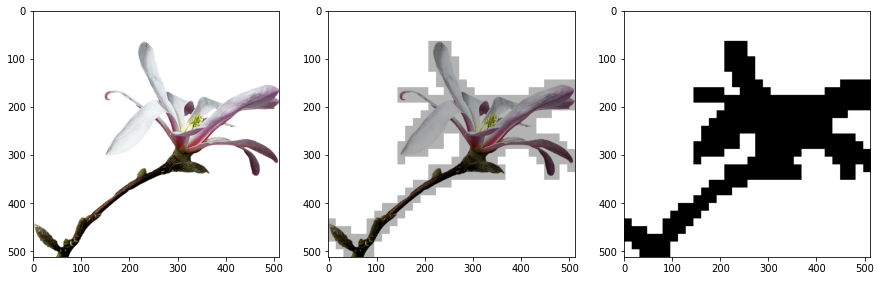

In [9]:
approx_obj = draw_from_tree(max_x=max_x, max_y=max_y)

plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.imshow(im)

plt.subplot(132)
plt.imshow(im)
plt.imshow(approx_obj, alpha=0.3)

plt.subplot(133)
plt.imshow(approx_obj)

plt.show()

### 2.4 Calculate the area
Calculate the area using the quadtree.  

In [10]:
approx_area = calc_area(x, y)
print('Area of the original object: {} px'.format(area))
print('Area of object searched by the proposed scheme: {} px'.format(approx_area))

Area of the original object: 40841 px
Area of object searched by the proposed scheme: 68864 px
